**About**

<p style='color:green'>Each year, natural disasters such as hurricanes, tornadoes, earthquakes and floods significantly damage infrastructure and result in loss of life, property and billions of dollars. As these events become more frequent and severe, there is an increasing need to rapidly develop maps and analyze the scale of destruction to better direct resources and first responders. </p>
    
<p style='color:green'>To help address this need, the SpaceNet 8 Flood Detection Challenge will focus on infrastructure and flood mapping related to hurricanes and heavy rains that cause route obstructions and significant damage. The goal of SpaceNet 8 is to leverage the existing repository of datasets and algorithms from SpaceNet Challenges 1-7 and apply them to a real-world disaster response scenario, expanding to multiclass feature extraction and characterization. </p>

* src : https://spacenet.ai/sn8-challenge/

# Dataset

Imagery consists of RGB (red, green, blue) image tiles of varied sizes and resolution (30-70 cm/pixel). Images are provided in GeoTiff format. For most tiles there are two images provided: before and after the event. For some tiles there are multiple post-event images (due to partial cloud cover or poor light conditions).

# References and Resources
* https://www.topcoder.com/challenges/a6c49990-e4a9-4e90-a731-4cc6502e6beb
* https://openaccess.thecvf.com/content/CVPR2022W/EarthVision/papers/Hansch_SpaceNet_8_-_The_Detection_of_Flooded_Roads_and_Buildings_CVPRW_2022_paper.pdf
* https://gis.stackexchange.com/questions/337983/mask-rasterio-raster-with-geopandas-shapefile
* https://github.com/avanetten/cresi/blob/main/notebooks/sn5_data_prep/cresi_sn5_data_prep.ipynb
* https://github.com/SpaceNetChallenge/SpaceNet8

* Modelling Notebook : https://www.kaggle.com/virajkadam/spacenet8-flood-detection

In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import seaborn as sns

# **installing aws cli**

In [2]:
!pip install awscli -q

# **List available datasets**

In [3]:
#model weights
# !aws s3 ls s3://spacenet-dataset/spacenet-model-weights/ --no-sign-request


In [4]:
!aws s3 ls s3://spacenet-dataset/spacenet/ --no-sign-request


                           PRE SN1_buildings/
                           PRE SN2_buildings/
                           PRE SN3_roads/
                           PRE SN4_buildings/
                           PRE SN5_roads/
                           PRE SN6_buildings/
                           PRE SN7_buildings/
                           PRE SN8_floods/


File association not found for extension .py


# **Downloading flooding dataset**

In [25]:
 train_s3_path_1='s3://spacenet-dataset/spacenet/SN8_floods/tarballs/Germany_Training_Public.tar.gz'
 train_s3_path_2='s3://spacenet-dataset/spacenet/SN8_floods/tarballs/Louisiana-East_Training_Public.tar.gz'
 storage_path_train = './train/'

 #test
 test_s3_path = 's3://spacenet-dataset/spacenet/SN8_floods/tarballs/Louisiana-West_Test_Public.tar.gz'
 storage_path_test = './test/'

  !aws s3 cp $train_s3_path_1 $storage_path_train --no-sign-request --recursive --quiet
  !aws s3 cp $train_s3_path_2 $storage_path_train --no-sign-request --recursive --quiet

IndentationError: unexpected indent (3009569340.py, line 9)

In [26]:
!aws s3 cp s3://spacenet-dataset/spacenet/SN8_floods/ ./train --no-sign-request --recursive
train_dir = './train'

^C


In [6]:
!ls -lh ./train/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# remove tarballs
!rm -r ./train/tarballs

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
#moving test dataset to ./test

test_dir = './test'
!mv ./train/Louisiana-West_Test_Public $test_dir

'mv' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
!ls -lh $test_dir

'ls' is not recognized as an internal or external command,
operable program or batch file.


# **Exploring data**

    lets explore the data , the subset for Lousiana East

In [10]:
!ls train/Louisiana-East_Training_Public/

'ls' is not recognized as an internal or external command,
operable program or batch file.


**Public Reference data**

In [11]:
pb_ref = pd.read_csv('./train/Louisiana-East_Training_Public/Louisiana-East_Training_Public_reference.csv')

# gpd.GeoSeries.from_wkt(pb_ref['Wkt_Pix'])
pb_ref.head()

ImageId Object  \
0  10400100684A4B00_1_14_93   Road   
1  10400100684A4B00_1_14_93   Road   
2   10400100684A4B00_1_5_97   Road   
3   10400100684A4B00_1_5_97   Road   
4  10300100AF395C00_2_15_45   Road   

                                             Wkt_Pix Flooded  \
0  LINESTRING (0 452.04956770450946, 1220.1471091...   False   
1  LINESTRING (1220.1471091017063 783.28148744750...   False   
2  LINESTRING (678.2789297711248 132.740937355459...   False   
3  LINESTRING (824.4727297903187 192.111332444852...   False   
4  LINESTRING (128.53377142171425 451.30968106585...    True   

             length_m       travel_time_s  
0  426.44631378041174  63.595549060548166  
1  28.000192402993623   4.175643104717493  
2  54.268734847067925   8.093046833552243  
3  171.63257977154112   25.59540977265884  
4  145.11690394540707   12.98469076104215

In [12]:
pb_ref.shape,pb_ref.ImageId.nunique()

((23663, 6), 599)

**image,label mapping csv**

In [13]:
lous_ds = pd.read_csv('./train/Louisiana-East_Training_Public/Louisiana-East_Training_Public_label_image_mapping.csv')
lous_ds.head()

label               pre-event image  \
0   1_7_88.geojson   10400100684A4B00_1_7_88.tif   
1  0_14_17.geojson  105001001A0FFC00_0_14_17.tif   
2  1_15_82.geojson  10400100684A4B00_1_15_82.tif   
3  2_20_59.geojson  10300100AF395C00_2_20_59.tif   
4   1_9_79.geojson   10400100684A4B00_1_9_79.tif   

             post-event image 1  post-event image 2  
0   10300100C46F5900_1_7_88.tif                 NaN  
1  10300100C46F5900_0_14_17.tif                 NaN  
2  10300100C46F5900_1_15_82.tif                 NaN  
3  10300100C46F5900_2_20_59.tif                 NaN  
4   10300100C46F5900_1_9_79.tif                 NaN

In [14]:
lous_ds['post-event image 1'].apply(lambda x:x.split('.')[0]).isin(pb_ref.ImageId).sum()

0

In [15]:
lous_ds['pre-event image'].apply(lambda x:x.split('.')[0]).isin(pb_ref.ImageId).sum()

599

# lets look at a sample image and labels : (pre image,post image, target)

**label annotations**

In [16]:
lab = gpd.read_file('train/Louisiana-East_Training_Public/annotations/1_7_88.geojson')

lab

id building flooded       highway lanes surface oneway bridge  \
0   way/847379047      yes    None          None  None    None   None   None   
1   way/847379048      yes    None          None  None    None   None   None   
2   way/847379049      yes    None          None  None    None   None   None   
3   way/847379197      yes    None          None  None    None   None   None   
4   way/847379199      yes    None          None  None    None   None   None   
5   way/847379205      yes    None          None  None    None   None   None   
6   way/847379206      yes    None          None  None    None   None   None   
7   way/847379207      yes    None          None  None    None   None   None   
8   way/847379208      yes    None          None  None    None   None   None   
9   way/847379473      yes    None          None  None    None   None   None   
10  way/847379474      yes    None          None  None    None   None   None   
11  way/847384252      yes    None          None  None    None   None   None   
12  way/847384268      yes    None          None  None    None   None   None   
13  way/847384271      yes    None          None  None    None   None   None   
14  way/847384273      yes    None          None  None    None   None   None   
15  way/847378570     None    None  unclassified     2   paved   None   None   
16  way/847378571     None    None  unclassified     2   paved   None   None   
17  way/847378586     None    None   residential     2   paved   None   None   
18  way/847378587     None    None   residential     2   paved   None   None   
19  way/847378588     None    None   residential     2   paved   None   None   
20  way/847378589     None    None   residential     2   paved   None   None   
21  way/847378598     None    None  unclassified     2   paved   None   None   
22  way/847378604     None    None  unclassified     2   paved   None   None   
23  way/847378608     None    None   residential     2   paved   None   None   

   layer tunnel  type          image_id                        location  \
0   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
1   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
2   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
3   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
4   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
5   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
6   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
7   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
8   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
9   None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
10  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
11  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
12  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
13  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
14  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
15  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
16  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
17  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
18  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
19  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
20  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
21  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
22  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   
23  None   None  None  10400100684A4B00  Louisiana-East_Training_Public   

                                             geometry  
0   POLYGON ((-90.02352 29.82381, -90.02339 29.823...  
1   POLYGON ((-90.02276 29

C:\Users\jpsre\AppData\Local\Temp\ipykernel_2684\247672287.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lab[lab['building']!='yes'].geometry.buffer(0.00001).plot(color = 'k',label = 'street',ax = ax)
C:\Users\jpsre\AppData\Local\Temp\ipykernel_2684\247672287.py:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


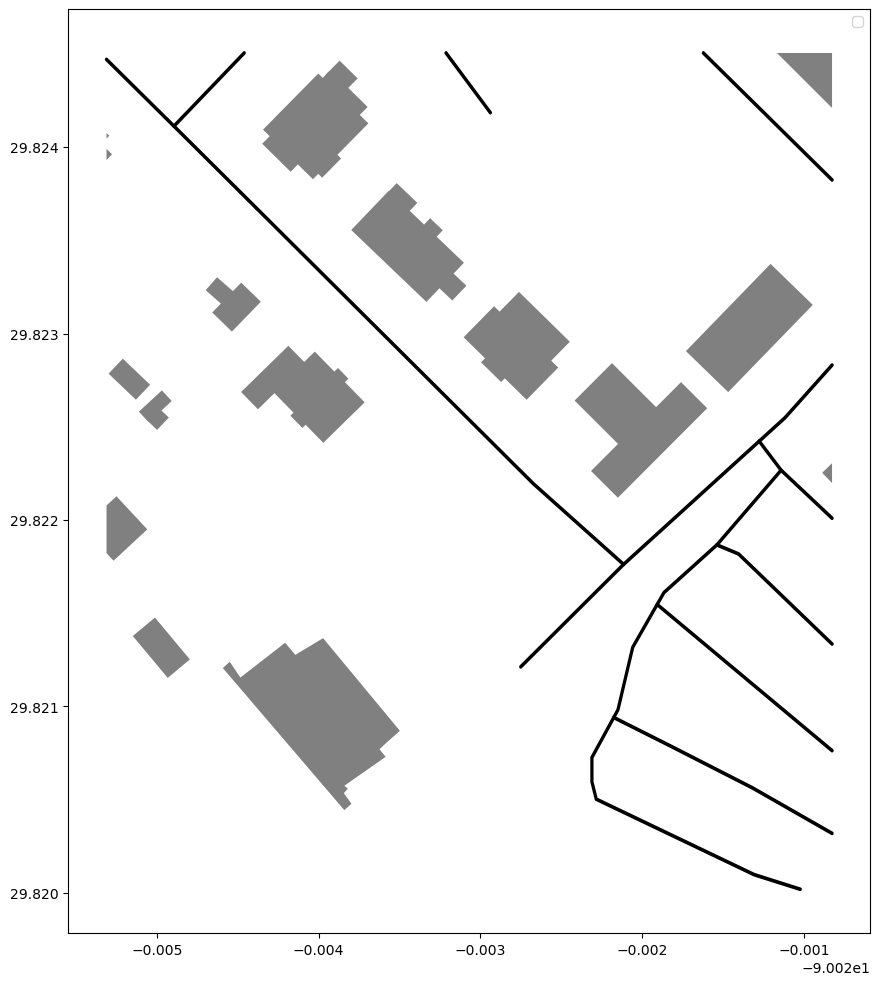

In [17]:
#gray color for building, black for streets
ax = lab[lab['building']=='yes'].plot(color = 'gray',label = 'buildings',figsize = (12,12))
lab[lab['building']!='yes'].geometry.buffer(0.00001).plot(color = 'k',label = 'street',ax = ax)
plt.legend()
plt.show()

**public references for selected example**

In [18]:
#pre event
pb_ref[pb_ref['ImageId']=='10400100684A4B00_1_7_88']

ImageId    Object  \
7479   10400100684A4B00_1_7_88      Road   
7480   10400100684A4B00_1_7_88      Road   
7481   10400100684A4B00_1_7_88      Road   
7482   10400100684A4B00_1_7_88      Road   
7483   10400100684A4B00_1_7_88      Road   
7484   10400100684A4B00_1_7_88      Road   
7485   10400100684A4B00_1_7_88      Road   
7486   10400100684A4B00_1_7_88      Road   
7487   10400100684A4B00_1_7_88      Road   
7488   10400100684A4B00_1_7_88      Road   
7489   10400100684A4B00_1_7_88      Road   
7490   10400100684A4B00_1_7_88      Road   
7491   10400100684A4B00_1_7_88      Road   
7492   10400100684A4B00_1_7_88      Road   
7493   10400100684A4B00_1_7_88      Road   
7494   10400100684A4B00_1_7_88      Road   
7495   10400100684A4B00_1_7_88      Road   
7496   10400100684A4B00_1_7_88      Road   
7497   10400100684A4B00_1_7_88      Road   
7498   10400100684A4B00_1_7_88      Road   
7499   10400100684A4B00_1_7_88      Road   
7500   10400100684A4B00_1_7_88      Road   
7501   10400100684A4B00_1_7_88      Road   
7502   10400100684A4B00_1_7_88      Road   
7503   10400100684A4B00_1_7_88      Road   
7504   10400100684A4B00_1_7_88      Road   
7505   10400100684A4B00_1_7_88      Road   
7506   10400100684A4B00_1_7_88      Road   
7507   10400100684A4B00_1_7_88      Road   
7508   10400100684A4B00_1_7_88      Road   
15249  10400100684A4B00_1_7_88  Building   
15250  10400100684A4B00_1_7_88  Building   
15251  10400100684A4B00_1_7_88  Building   
15252  10400100684A4B00_1_7_88  Building   
15253  10400100684A4B00_1_7_88  Building   
15254  10400100684A4B00_1_7_88  Building   
15255  10400100684A4B00_1_7_88  Building   
15256  10400100684A4B00_1_7_88  Building   
15257  10400100684A4B00_1_7_88  Building   
15258  10400100684A4B00_1_7_88  Building   
15259  10400100684A4B00_1_7_88  Building   
15260  10400100684A4B00_1_7_88  Building   
15261  10400100684A4B00_1_7_88  Building   
15262  10400100684A4B00_1_7_88  Building   
15263  10400100684A4B00_1_7_88  Building   

                                                 Wkt_Pix Flooded  \
7479   LINESTRING (742.2065254671525 954.217636287001...   False   
7480   LINESTRING (926.4924637423958 795.007572892546...   False   
7481   LINESTRING (1169.4820397407493 603.47427193623...   False   
7482   LINESTRING (1215.7492030985923 567.00554292135...   False   
7483   LINESTRING (0 10.050209395855214, 120.84663857...   False   
7484   LINESTRING (120.8466385774106 113.755480798339...   False   
7485   LINESTRING (291.2176405015498 260.731995986021...   False   
7486   LINESTRING (764.7603181329896 669.541230143647...   False   
7487   LINESTRING (1169.4820397407493 603.47427193623...   False   
7488   LINESTRING (1208.7337560229678 648.61084671897...   False   
7489   LINESTRING (1299.9999999995496 1213.0957031984...   False   
7490   LINESTRING (1157.422428237283 1142.41715040983...   False   
7491   LINESTRING (1011.228628218089 1077.65471748392...   False   
7492   LINESTRING (1208.7337560229678 648.61084671897...   False   
7493   LINESTRING (1093.674626086331 764.655617980536...   False   
7494   LINESTRING (998.7921538569418 838.868611842793...   False   
7495   LINESTRING (986.6455740023367 857.305902505637...   False   
7496   LINESTRING (942.8135245010963 923.865681374992...   False   
7497   LINESTRING (916.3751454377061 1020.98034131279...   False   
7498   LINESTRING (908.8378882470097 1033.01096336416...   False   
7499   LINESTRING (869.7311192180623 1095.19333517401...   False   
7500   LINESTRING (869.7311192180623 1132.96658947245...   False   
7501   LINESTRING (877.5002920131686 1159.95576809992...   False   
7502   LINESTRING (1160.5242994622283 1277.3340540950...   False   
7503   LINESTRING (1299.9999999995496 918.71454943273...   False   
7504   LINESTRING (1132.5494795108687 778.83145938608...   False   
7505   LINESTRING (1299.9999999995496 197.29169710755...   False   
7506   LINESTRING (120.8466385774106 113.755480798339...   False   
7507   LINESTRING (608.351

In [19]:
#post event
pb_ref[pb_ref['ImageId']=='10300100C46F5900_1_7_88']

Empty DataFrame
Columns: [ImageId, Object, Wkt_Pix, Flooded, length_m, travel_time_s]
Index: []

**Checking the pre/post images**

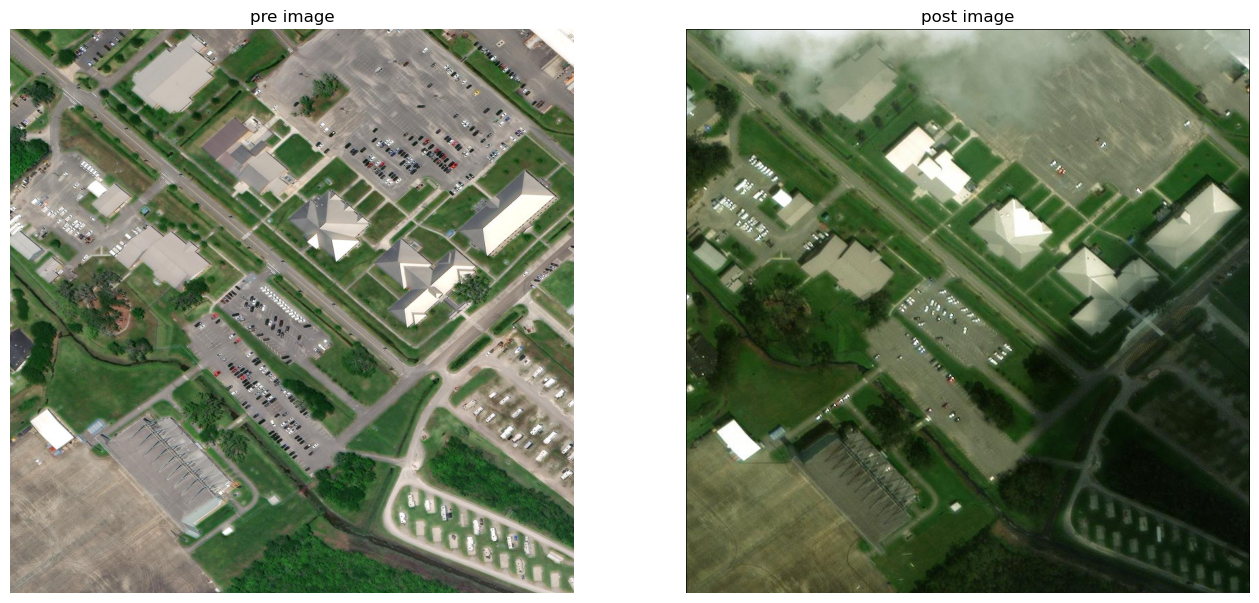

In [20]:
pre_image = rio.open('train/Louisiana-East_Training_Public/PRE-event/10400100684A4B00_1_7_88.tif').read().transpose((1,2,0))
post_image = rio.open('train/Louisiana-East_Training_Public/POST-event/10300100C46F5900_1_7_88.tif').read().transpose((1,2,0))



plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
plt.title('pre image')
plt.axis('off')
plt.imshow(pre_image)

plt.subplot(1,2,2)
plt.title('post image')
plt.axis('off')
plt.imshow(post_image)

plt.show()

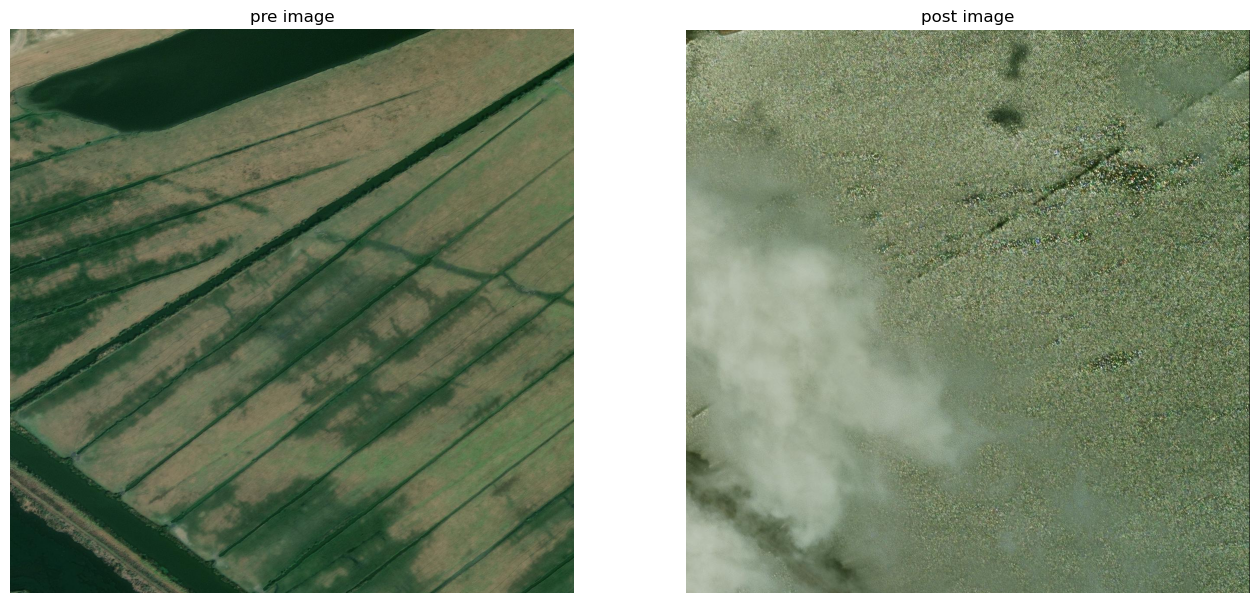

In [21]:
pre_image = rio.open('train/Louisiana-East_Training_Public/PRE-event/105001001A0FFC00_0_14_17.tif').read().transpose((1,2,0))
post_image = rio.open('train/Louisiana-East_Training_Public/POST-event/10300100C46F5900_0_14_17.tif').read().transpose((1,2,0))



plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
plt.title('pre image')
plt.axis('off')
plt.imshow(pre_image)

plt.subplot(1,2,2)
plt.title('post image')
plt.axis('off')
plt.imshow(post_image)

plt.show()

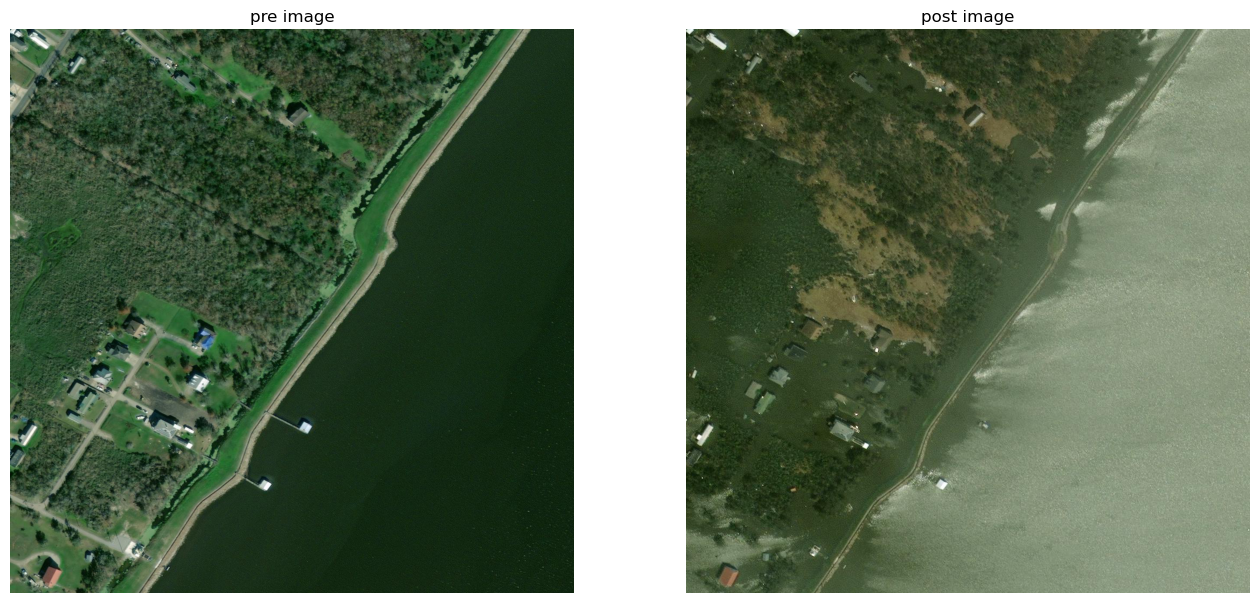

In [22]:

pre_image = rio.open('train/Louisiana-East_Training_Public/PRE-event/10300100AF395C00_2_20_59.tif').read().transpose((1,2,0))
post_image = rio.open('train/Louisiana-East_Training_Public/POST-event/10300100C46F5900_2_20_59.tif').read().transpose((1,2,0))



plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
plt.title('pre image')
plt.axis('off')
plt.imshow(pre_image)

plt.subplot(1,2,2)
plt.title('post image')
plt.axis('off')
plt.imshow(post_image)

plt.show()

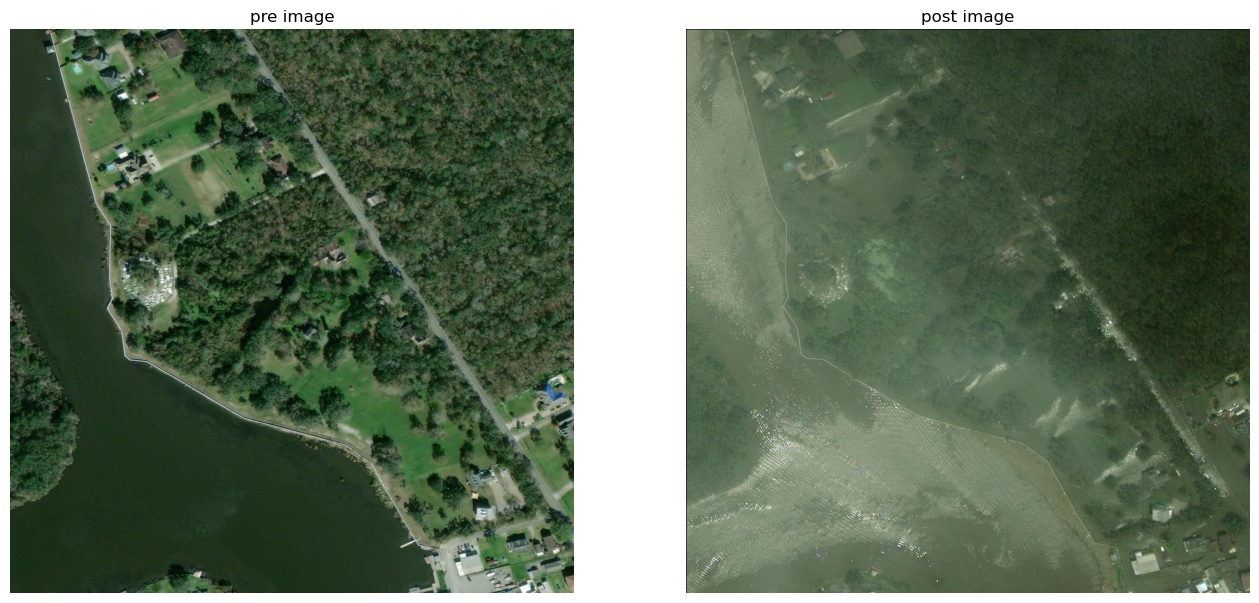

In [23]:

pre_image = rio.open('train/Louisiana-East_Training_Public/PRE-event/10300100AF395C00_2_14_47.tif').read().transpose((1,2,0))
post_image = rio.open('train/Louisiana-East_Training_Public/POST-event/10300100C46F5900_2_14_47.tif').read().transpose((1,2,0))



plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
plt.title('pre image')
plt.axis('off')
plt.imshow(pre_image)

plt.subplot(1,2,2)
plt.title('post image')
plt.axis('off')
plt.imshow(post_image)

plt.show()

**Next Notebook in the series**

* https://www.kaggle.com/virajkadam/spacenet8-flood-detection

In [27]:
1500 + 300 + 1000 

2800